## Librairies

In [ ]:
!pip install pingouin;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=522474f41eae5e119aa67d44dfbee52e14a98e6ccb5af0136b32ef0c81dd35a1
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import ceil
from prophet import Prophet

sns.set_theme()
pd.set_option('display.width', 1000)
# Define the tickers you want to get data for
tickers = ['CL=F', '^STOXX50E', '^TNX', '^GSPC']

# Define the start and end dates for the data
start_date = '2017-01-01'
end_date = '2021-06-01'

threshold = 'std' # 'std or 'q'

returns = {
    'features': {
      '1d_return' : 1,
      '7d_return' : 7,
      '30d_return' : 30,
      '90d_return' : 90,
    },
    'target' : {
      '30d_return' : 30,
      '90d_return' : 90,
      '180d_return' : 180,
    }
}

feature_return_names = list(returns['features'].keys())
target_return_names = list(returns['target'].keys())


# Data acquisition

In [ ]:
# Use yfinance to get the adjusted price for every tickers
data = yf.download(tickers, start=start_date, end=end_date).loc[:, 'Adj Close'].dropna()

file_path = 'https://raw.githubusercontent.com/CossonArthur/Gas-price-prediction/main/NGAS_TS%20-%20Historical%20Data.csv'
dataNGAS = pd.read_csv(file_path, parse_dates=['Date']).set_index('Date')
dataNGAS.rename(columns={'Price': 'NGAS.L'}, inplace=True)

[*********************100%***********************]  4 of 4 completed


In [ ]:
data = data.merge(dataNGAS, left_index=True, right_index=True, how='left')

We selected a mix of macro, equities and fixed income variables. Eurostoxx and SP500 are the two main equity indices for Europe and US. TNX instead is the reference yield of the US 10 years government bond. The fixed income market is important for commodities pricing as discounting inflation expectations and market risk sentiment. The time series are available in the price domain, so we had to transform into returns at various frequencies. Given the nature of the asset class, we assumed a fixed duration for the 10 year government bond and used a first order linear approximation to estimate returns. For each time series we also calculated a momentum signal through trend filtering. We used for this a simple common used method, which is the difference of two exponentially weighted moving averages with different half lives. This is a simple proxy of the time series gradient and the method is called "moving average crossover".




In the above code: 

1.   CL=F is the ticker symbol for crude oil futures
2.   ^STOXX50E is the ticker symbol for the Euro
3.   Stoxx 50 index
4.   ^TNX is the ticker symbol for the 10-year US Treasury yield
5. ^GSPC is the ticker symbol for the S&P 500 index


## Filling missing data

In [ ]:
# here we check for data missing
dates_check = data.reset_index()['Date']

In [ ]:
dates_check['check'] =  dates_check.diff()
dates_check['check'].max()

Timedelta('6 days 00:00:00')

##  Features calculation
EMAS, MOMENTUM AND RETURNS




In [ ]:
# Calculate the EMAs with half-life of 5, 10, and 30 days
for ticker in tickers:
    data[ticker + '_ema_5'] = data[ticker].ewm(halflife=5).mean()
    data[ticker + '_ema_10'] = data[ticker].ewm(halflife=10).mean()
    data[ticker + '_ema_30'] = data[ticker].ewm(halflife=30).mean()

# Calculate fast and slow momentum for each ticker
for ticker in tickers:
    data[ticker + '_fast_momentum'] = data[ticker + '_ema_5'] - data[ticker + '_ema_10']
    data[ticker + '_slow_momentum'] = data[ticker + '_ema_10'] - data[ticker + '_ema_30']

# Calculate rolling returns for each ticker 
for ticker in tickers:
    if ticker == '^TNX':
        # Calculate returns for ^TNX with a different formula as this is a bond
        for key, val in returns['features'].items():
          data[ticker + '_' + key] = (data[ticker] - data[ticker].shift(val))/100 * -7 
    else:
        #https://www.wikiwand.com/en/Rate_of_return#Logarithmic_or_continuously_compounded_return
        for key, val in returns['features'].items():
            data[ticker + '_' + key] = np.log(data[ticker] / data[ticker].shift(val)) # ln(V_t/V_t-val)

for key, val in returns['target'].items():
  data['target_' + key] = np.log(data['NGAS.L'].shift(-val) / data['NGAS.L']) # ln(V_t+val/V_t)

data.dropna(inplace = True)

Y = data.loc[:,['target_' + key for key in target_return_names]]
Y.rename(columns={'target_' + key: key for key in target_return_names},inplace=True)
data = data.drop(columns=['target_' + key for key in target_return_names]+['NGAS.L'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Data analysis

Text(0.5, 1.0, 'Return for : NGAS.L')

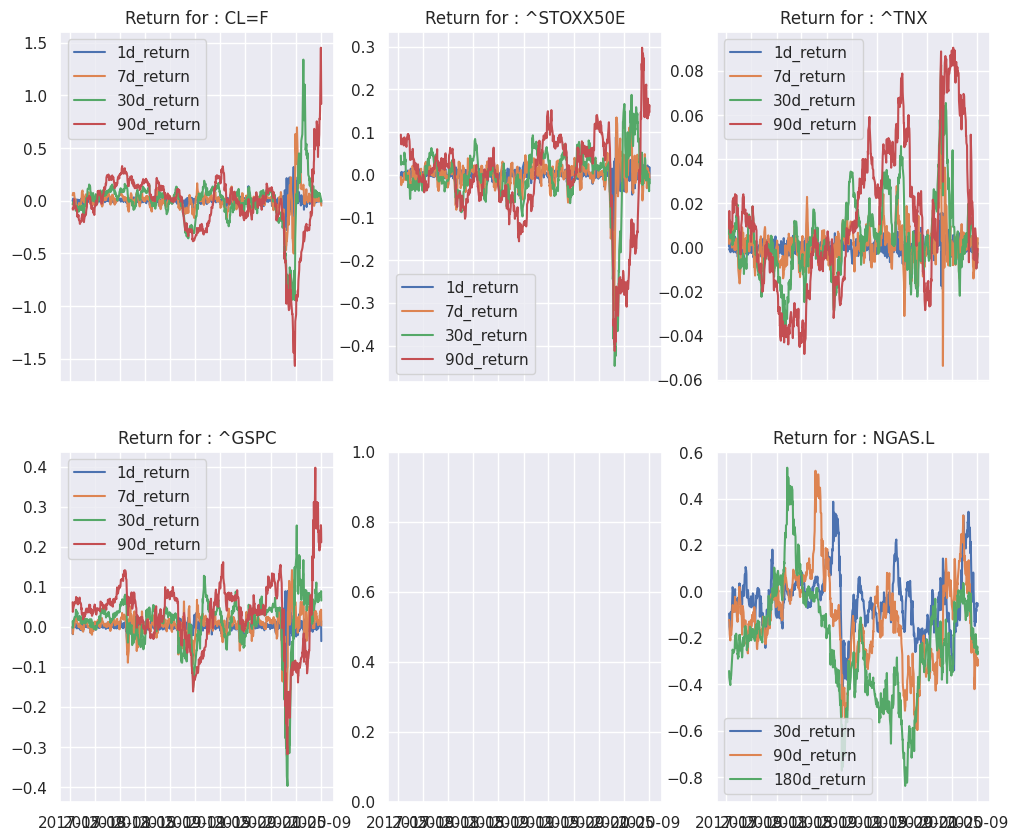

In [ ]:
fig, axs = plt.subplots(ceil((len(tickers)+1)/3),3,figsize=(12*ceil((len(tickers)+1)//3), 10),sharex='all')


for i in range(len(tickers)):
  for x in feature_return_names:
    axs[i//3,i%3].plot(data[tickers[i] + '_' + x])
  axs[i//3,i%3].legend(feature_return_names)
  axs[i//3,i%3].set_title('Return for : {}'.format(tickers[i]))


index_plot = len(tickers)+1
for x in target_return_names:
  axs[index_plot//3,index_plot%3].plot(Y[x])
axs[index_plot//3,index_plot%3].legend(target_return_names)
axs[index_plot//3,index_plot%3].set_title('Return for : {}'.format('NGAS.L'))


## Time series seasonnal decomposition (spoiler: no trend )

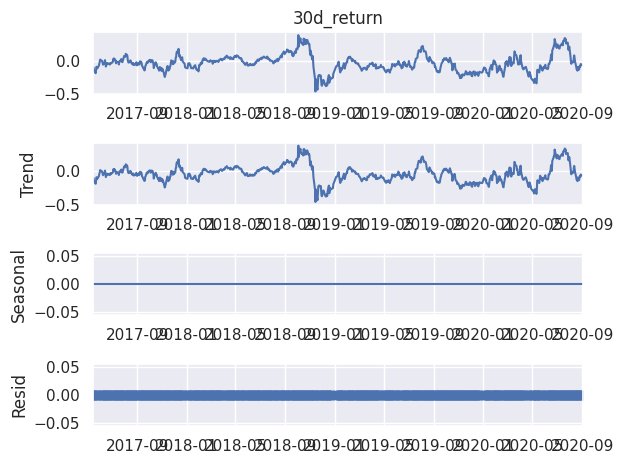

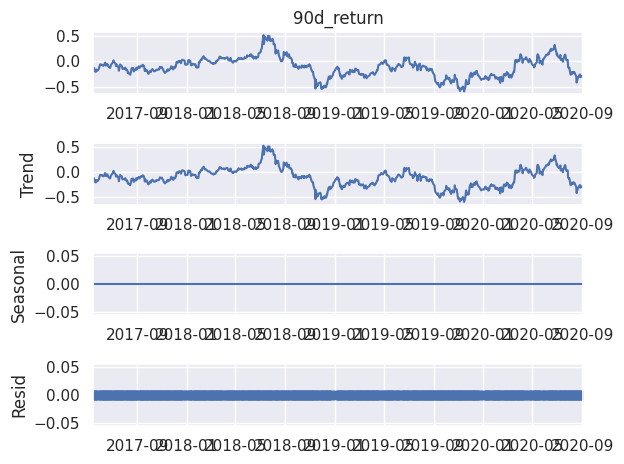

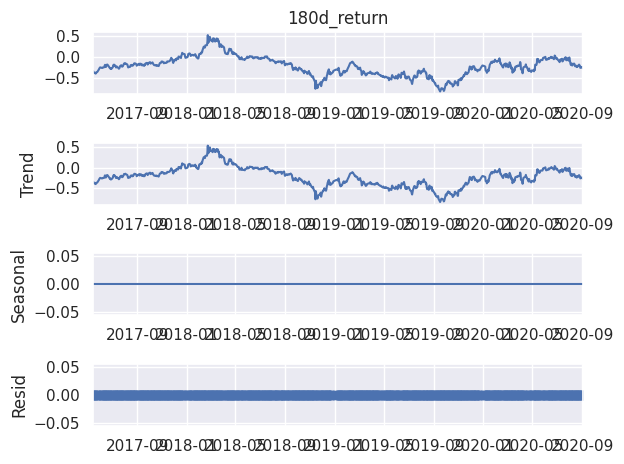

In [ ]:
import statsmodels.api as sm

for x in target_return_names:
  decomposition = sm.tsa.seasonal_decompose(Y[x], model = 'additive',period=1)
  decomposition.plot()

## Normality test

                                W          pval  normal
CL=F                     0.945202  1.522011e-16   False
^GSPC                    0.977966  1.451649e-09   False
^STOXX50E                0.928130  4.926870e-19   False
^TNX                     0.901961  4.062037e-22   False
CL=F_ema_5               0.934265  3.409265e-18   False
CL=F_ema_10              0.933408  2.582307e-18   False
CL=F_ema_30              0.929600  7.742850e-19   False
^STOXX50E_ema_5          0.933020  2.278982e-18   False
^STOXX50E_ema_10         0.942607  5.901535e-17   False
^STOXX50E_ema_30         0.951354  1.643620e-15   False
^TNX_ema_5               0.898492  1.769806e-22   False
^TNX_ema_10              0.897193  1.303743e-22   False
^TNX_ema_30              0.897628  1.443729e-22   False
^GSPC_ema_5              0.976081  4.168937e-10   False
^GSPC_ema_10             0.978288  1.807846e-09   False
^GSPC_ema_30             0.975241  2.438516e-10   False
CL=F_fast_momentum       0.872492  6.365459e-25 

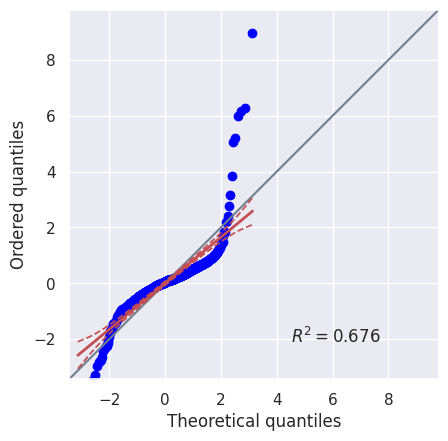

In [ ]:
result = pg.normality(data)
print(result)

ax = pg.qqplot(data['CL=F_1d_return'], dist='norm')

## Correlation analysis

### Correlation with inputs

In [ ]:
#print(pg.pairwise_corr(data, method='spearman'))

df = data.rcorr(decimals=2,upper='n',method='spearman').replace(['-',data.shape[0]],0).astype('float')
px.imshow(df)

### Correlation with target

In [ ]:
# TODO : corr targets
from scipy.stats import spearmanr

temp = pd.DataFrame(index=target_return_names)
for y in data.columns:
  L = []
  for x in target_return_names:
    L.append(spearmanr(Y[x],data[y]).statistic)
  temp[y] = L

px.imshow(temp)

# Data preprocessing

## Data selection


## PCA


In [ ]:
input_columns = [col for col in data.columns if not('NGAS' in col)]
X = data[input_columns]

print('Number of initial features : {}'.format(len(input_columns)))

Number of initial features : 40


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

date_index = X.index

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pca = PCA()
X_hat = pca.fit_transform(X)

X_hat = pd.DataFrame(index=date_index,data=X_hat)

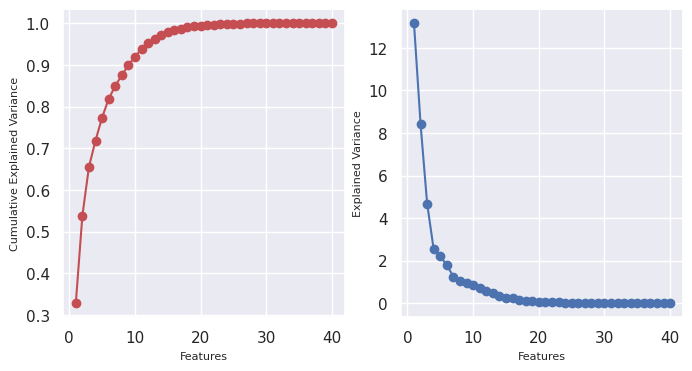

In [ ]:
prop_var = pca.explained_variance_ratio_

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(range(1,len(prop_var)+1),np.cumsum(prop_var), 'ro-')
axs[0].set_xlabel('Features', fontsize=8)
axs[0].set_ylabel('Cumulative Explained Variance', fontsize=8)
axs[1].plot(range(1,len(prop_var)+1),pca.explained_variance_,'bo-')
axs[1].set_ylabel('Explained Variance', fontsize=8)
axs[1].set_xlabel('Features', fontsize=8)
plt.show()

In [ ]:
def biplot(score,coef,labels=None,represent = None):
  
    if (represent != None):
       labels = [ticker if ticker in represent else ' ' for ticker in labels]

    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,
                s=5, 
                color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
 
 
    plt.figure()

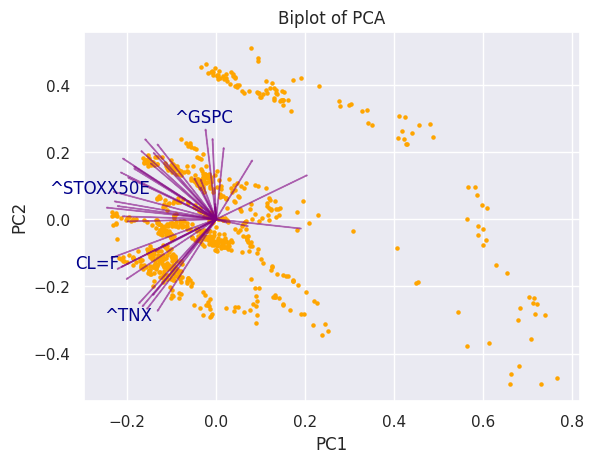

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.title('Biplot of PCA')
 
biplot(X_hat, np.transpose(pca.components_), input_columns,tickers)

In [ ]:
#@title PCA choice
max_component = 20 #@param {type:"slider", min:0, max:45, step:1}
# 12 seems to be a good choice

print('Amount of variance explained by the choice of principal components : {}'.format(round(np.sum(prop_var[:max_component+1]),3)))

weights = pd.DataFrame(np.transpose(pca.components_), index=input_columns)
fig = px.bar(weights.loc[:,:max_component],title="Weight")
fig.show() # double clicked on a component in the legend to isolate


Amount of variance explained by the choice of principal components : 0.996


## Input / output data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# input vector
X_hat_reduced = X_hat.loc[:,:max_component] #keep only the principals components

Y_class =  pd.DataFrame() # target vector for class 

if(threshold == 'q'):
  for x in target_return_names:
    Y_class[x] = np.where(Y[x] >= Y[x].quantile(0.75),'High Profit', 
                          np.where(Y[x] >= Y[x].quantile(0.5),'Marginal Profit',     
                              np.where(Y[x] >= Y[x].quantile(0.25),'Marginal Loss', 'High loss')
                          )
                )
elif(threshold == 'std'):
  for x in target_return_names:
    Y_class[x] = np.where(Y[x] >= Y[x].std(),'High Profit', 
                          np.where(Y[x] >= 0,'Marginal Profit',     
                              np.where(Y[x] >= -Y[x].std(),'Marginal Loss', 'High loss')
                          )
                )

print(pd.concat([Y_class[x].value_counts() for x in target_return_names],axis=1))

# Encode target classes as numerical labels
le = LabelEncoder()
Y_class_encoded = np.transpose(np.array([le.fit_transform(Y_class[x]) for x in Y_class.columns]))
target_names = le.classes_

# Split data into training and testing sets
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_hat_reduced, Y_class_encoded, test_size=0.2, random_state=17)
X_train, X_test, Y_train, Y_test = train_test_split(X_hat_reduced, Y, test_size=0.2, random_state=17)


                 30d_return  90d_return  180d_return
Marginal Loss           365         310          324
Marginal Profit         186         182           75
High loss               161         264          363
High Profit              81          37           31


# Prediction models 



## Classification
 

In [ ]:
from sklearn.metrics import classification_report

def class_report(Y_test,Y_pred,name=''):
  '''
  Print classification report
  '''
  print(name)
  print('-'*60)
  print(classification_report(Y_test, Y_pred, target_names=target_names))
  print('='*60)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define class weights
class_weights = {0: 0.5,1: 1, 2: 0.5, 3: 1}
for i in range(Y_class.shape[1]):
  # Train a random forest classifier on the training set
  rf_classifier = RandomForestClassifier(n_estimators=300, random_state=42, class_weight=class_weights)
  rf_classifier.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = rf_classifier.predict(X_test_class)
  delta = Y_pred-Y_test_class[:,i]

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])


30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.85      0.73      0.79        15
      High loss       0.93      0.73      0.82        37
  Marginal Loss       0.68      0.88      0.77        73
Marginal Profit       0.70      0.47      0.56        34

       accuracy                           0.74       159
      macro avg       0.79      0.70      0.73       159
   weighted avg       0.76      0.74      0.74       159

90d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       1.00      0.67      0.80        12
      High loss       0.89      0.93      0.91        54
  Marginal Loss       0.81      0.84      0.82        56
Marginal Profit       0.81      0.81      0.81        37

       accuracy                           0.85       159
      macro avg       0.88      0.81      0.84       

**Metrics and definition** 
* **Precision** ->	Precision is defined as the ratio of true positives to the sum of true and false positives.
* **Recall** ->	Recall is defined as the ratio of true positives to the sum of true positives and false negatives.
* **F1 Score**	-> The F1 is the weighted harmonic mean of precision and recall. The closer the value of the F1 score is to 1.0, the better the expected performance of the model is.
* **Support** ->	Support is the number of actual occurrences of the class in the dataset. It doesn’t vary between models, it just diagnoses the performance evaluation process.


### Probabilistic discriminative approach: Logistic Regression

Let us change the methods for the classification task and use a Logistic regression classifier with two classes:
- Hypothesis space: $y_n = y(x_n) = \sigma(w_0 + x_{n1} w_1 + x_{n2} w_2)$;
- Loss measure: Loglikelihood $L(\mathbf{w}) = -\sum_{n=1}^N  [C_n \ln y_n + (1 - C_n) \ln (1 - y_n)]$;
- Optimization method: Gradient Descent;

where the sigmoid function is defined as $\sigma(x) = \frac{1}{1 + e^{-x}}$.
* Pros:
  * Can be simpler and faster to train, since it only needs to estimate the conditional distribution of the labels given the features.
  * May be more effective at capturing the decision boundaries between classes, since it focuses on modeling the conditional distribution of the labels.
  * Can be more interpretable, since it provides a clear probabilistic interpretation of the classification decision.
* Cons:
  * Can be less robust to missing data and noisy data, since it only models the conditional distribution of the labels given the features.
  * May be more prone to overfitting, since it only models the conditional distribution of the labels given the features and may not capture the full distribution of the data.




In [ ]:
from sklearn.linear_model import LogisticRegression

for i in range(Y_class.shape[1]):
  # Train a Logistic Regression classifier on the training set
  log_classifier = LogisticRegression(penalty=None) # regularization is applied as default
  log_classifier.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = log_classifier.predict(X_test_class)

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])

1d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       1.00      0.05      0.10        19
      High loss       0.14      0.05      0.07        21
  Marginal Loss       0.40      0.58      0.47        67
Marginal Profit       0.46      0.47      0.47        70

       accuracy                           0.42       177
      macro avg       0.50      0.29      0.28       177
   weighted avg       0.46      0.42      0.38       177

30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.46      0.25      0.32        24
      High loss       0.64      0.60      0.62        30
  Marginal Loss       0.59      0.76      0.66        79
Marginal Profit       0.44      0.34      0.38        44

       accuracy                           0.56       177
      macro avg       0.53      0.49      0.50       1

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



### Probabilistic generative approach: Naive Bayes


Generative models have the purpose of modeling the joint pdf of the couple input/output $p(C_k,\mathbf{x})$, which allows us to generate also **new data** from what we learned.

This is different from the probabilistic discriminative models, in which we are only interested in computing the probabilities that a given input is coming from a specific class $p(C_k | \mathbf{x})$, which is not sufficient to produce new samples.

Conversely, we will see how it is possible to generate new samples if we are provided with an approximation of the joint input/output distribution $p(C_k,\mathbf{x})$.

In this case, the Naive Bayes method considers the **naive assumption** that each input is conditionally (w.r.t. the class) independent from each other.
If we consider the Bayes formula we have: 
\begin{align*}
	& p(C_k | \mathbf{x}) = \frac{p(C_k) \ p(\mathbf{x} | C_k)}{p(\mathbf{x})} \\
	& \propto p(x_1, \ldots, x_M, C_k)\\
	& = p(x_1 | x_2, \ldots, x_M, C_k) p(x_2, \ldots, x_M, C_k) \\
	& = p(x_1 | x_2, \ldots, x_M, C_k) p(x_2 | x_3, \ldots, x_M, C_k) p(x_3, \ldots, x_n, C_k) \\
	& = p(x_1 \vert x_2, \ldots, x_M, C_k) \ldots p(x_M | C_k) p(C_k) \\
	& = p(x_1 \vert C_k) \ldots p(x_M | C_k) p(C_k) \\
	& = p(C_k) \prod_{j=1}^M p(x_j | C_k).
\end{align*}

The decision function, which maximises the Maximum A Posteriori probability, is the following:
\begin{equation*}
	y(\mathbf{x}) = \arg \max_k p(C_k) \prod_{j=1}^M p(x_j | C_k),
\end{equation*}
where as usual we do not consider the normalization factor $p(\mathbf{x})$.

In a specific case we have to define a prior distribution for the classes $p(C_k) \ \forall k$ and a distribution to compute the likelihood of the considered samples $p(x_j | C_k) \ \forall J, \ \forall k$.

In the case of continuous variable one of the usual assumption is to use Gaussian distributions for each variable $p(x_j | C_k) = \mathcal{N}(x_j;\mu_{jk},\sigma^2_{jk})$ and either a uniform prior $p(C_k) = \frac{1}{K}$ or a multinomial prior based on the samples proportions $p(C_k) = \frac{\sum_{i=1}^N I \{\mathbf{x}_n \in C_k \}}{N}$, where $I\{\cdot\}$ is the indicator function.

The complete model of Naive Bayes is:
- Hypothesis space: $y_n = y(x_n) = \arg \max_k p(C_k) \prod_{j=1}^M p(x_j | C_k)$;
- Loss measure: Log likelihood;
- Optimization method: MLE.

* Pros:
 * Can handle missing data and noisy data well, since it models the joint distribution of features and labels.
  * Can be more robust to overfitting, since it estimates the full distribution of the data rather than just the conditional distribution of the labels.
  * Can be useful for generating synthetic data that follows the same distribution as the training data.
* Cons:
  * Can be computationally more expensive, since it involves estimating the joint distribution.
  * Can suffer from the curse of dimensionality when dealing with high-dimensional feature spaces.
  * May not be as good at capturing the subtle decision boundaries between classes, since it models the distribution of the data as a whole rather than just the boundaries between classes.
 

In [ ]:
from sklearn.naive_bayes import GaussianNB

for i in range(Y_class.shape[1]):

  # Train a Naive Bayes classifier on the training set
  gnb_classifier = GaussianNB()
  gnb_classifier.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = gnb_classifier.predict(X_test_class)

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])

1d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       1.00      0.11      0.19        19
      High loss       0.28      0.24      0.26        21
  Marginal Loss       0.39      0.60      0.47        67
Marginal Profit       0.36      0.29      0.32        70

       accuracy                           0.38       177
      macro avg       0.51      0.31      0.31       177
   weighted avg       0.43      0.38      0.36       177

30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.50      0.21      0.29        24
      High loss       0.43      0.43      0.43        30
  Marginal Loss       0.56      0.61      0.59        79
Marginal Profit       0.35      0.41      0.38        44

       accuracy                           0.47       177
      macro avg       0.46      0.41      0.42       1

### Quadratic Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

for i in range(Y_class.shape[1]):

  # Train a Naive Bayes classifier on the training set
  QDA_classifier = QuadraticDiscriminantAnalysis()
  QDA_classifier.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = QDA_classifier.predict(X_test_class)

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])

1d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.00      0.00      0.00        19
      High loss       0.30      0.29      0.29        21
  Marginal Loss       0.42      0.67      0.51        67
Marginal Profit       0.39      0.26      0.31        70

       accuracy                           0.39       177
      macro avg       0.28      0.30      0.28       177
   weighted avg       0.35      0.39      0.35       177

30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.75      0.62      0.68        24
      High loss       0.65      0.57      0.61        30
  Marginal Loss       0.56      0.59      0.58        79
Marginal Profit       0.45      0.48      0.46        44

       accuracy                           0.56       177
      macro avg       0.60      0.57      0.58       1

###SVM

In [ ]:
from sklearn.svm import LinearSVC

for i in range(Y_class.shape[1]):

  # Train a Naive Bayes classifier on the training set
  svm_classifier = LinearSVC(max_iter=3000)
  svm_classifier.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = svm_classifier.predict(X_test_class)

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.54      0.47      0.50        15
      High loss       0.87      0.73      0.79        37
  Marginal Loss       0.59      0.74      0.66        73
Marginal Profit       0.50      0.35      0.41        34

       accuracy                           0.63       159
      macro avg       0.63      0.57      0.59       159
   weighted avg       0.63      0.63      0.62       159



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



90d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.00      0.00      0.00        12
      High loss       0.61      0.74      0.67        54
  Marginal Loss       0.55      0.57      0.56        56
Marginal Profit       0.60      0.57      0.58        37

       accuracy                           0.58       159
      macro avg       0.44      0.47      0.45       159
   weighted avg       0.54      0.58      0.56       159

180d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.91      1.00      0.95        10
      High loss       0.75      0.79      0.77        75
  Marginal Loss       0.68      0.65      0.66        62
Marginal Profit       0.30      0.25      0.27        12

       accuracy                           0.70       159
      macro avg       0.66      0.67      0.66      

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



### Perceptron

In [ ]:
from sklearn.linear_model import Perceptron

for i in range(Y_class.shape[1]):

  # Train a Naive Bayes classifier on the training set
  per_classifier = Perceptron()
  per_classifier.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = per_classifier.predict(X_test_class)

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])

30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.24      0.40      0.30        15
      High loss       0.72      0.62      0.67        37
  Marginal Loss       0.59      0.71      0.65        73
Marginal Profit       0.29      0.12      0.17        34

       accuracy                           0.53       159
      macro avg       0.46      0.46      0.44       159
   weighted avg       0.52      0.53      0.52       159

90d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.00      0.00      0.00        12
      High loss       0.45      0.76      0.56        54
  Marginal Loss       0.58      0.34      0.43        56
Marginal Profit       0.61      0.46      0.52        37

       accuracy                           0.48       159
      macro avg       0.41      0.39      0.38       

## Regression

all the point should be on red line (prediction = test)

misclassified loss : not good <=> predict loss but actually is profit
--> infinite loss 

misclassified profit : less not good <=> predict profit but actually is loss
--> actif price loss

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def regression_report(Y_test,Y_pred,name=''):
  print(name)
  print('-'*60)
  print('R²: ',r2_score(Y_test, Y_pred))
  print('Mean absolute error : ',mean_absolute_error(Y_test, Y_pred))
  print('% of missclassified sign : ', round(np.count_nonzero(Y_test * Y_pred < 0) / Y_pred.shape[0] * 100)) # top left and bottom right)
  print('% of missclassified profit : ', round(np.count_nonzero(np.logical_and(Y_test < 0, Y_pred > 0)) / Y_pred.shape[0] * 100)) # top left 
  print('% of missclassified loss : ', round(np.count_nonzero(np.logical_and(Y_test > 0, Y_pred < 0)) / Y_pred.shape[0] * 100)) # bottom right
  dataMin,dataMax = min([Y_test.min(), Y_pred.min()]),max([Y_test.max(), Y_pred.max()])
  fig, axs = plt.subplots(1,2,figsize=(10, 5))
  axs[0].plot([dataMin,dataMax],[dataMin,dataMax],'r-')
  axs[0].scatter(Y_test, Y_pred)
  axs[0].set_title('Accuracy of prediction')
  axs[0].set_xlabel('Real values')
  axs[0].set_ylabel('Predicted values')
  axs[1].scatter(Y_pred, Y_test-Y_pred)
  axs[1].set_title('Residual analysis')
  axs[1].set_xlabel('Predicted values')
  axs[1].set_ylabel('Residual values')

  plt.show()
  print('='*60)

### Ridge

In [ ]:
Y_train

,30d_return,90d_return,180d_return
Date,,,
2020-03-13,-0.028499,-0.264258,-0.379710
2017-10-20,-0.082344,-0.163924,-0.199551
2020-01-06,-0.110453,-0.296148,-0.231569
2020-01-24,-0.077272,-0.268990,-0.107706
2020-01-09,-0.177211,-0.343164,-0.338407
...,...,...,...
2019-01-24,-0.062081,-0.300829,-0.353193
2018-12-21,-0.276286,-0.341099,-0.421706
2017-12-12,0.179964,0.007678,0.012763


30d_return
------------------------------------------------------------
R²:  0.39451791883430964
Mean absolute error :  0.08418057566930026
% of missclassified sign :  33
% of missclassified profit :  21
% of missclassified loss :  11


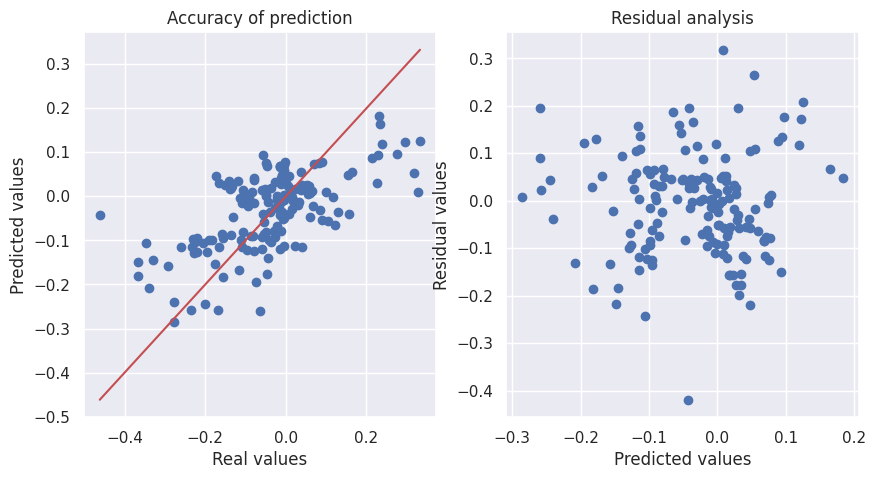

90d_return
------------------------------------------------------------
R²:  0.4060216111811614
Mean absolute error :  0.13462932398985325
% of missclassified sign :  25
% of missclassified profit :  9
% of missclassified loss :  16


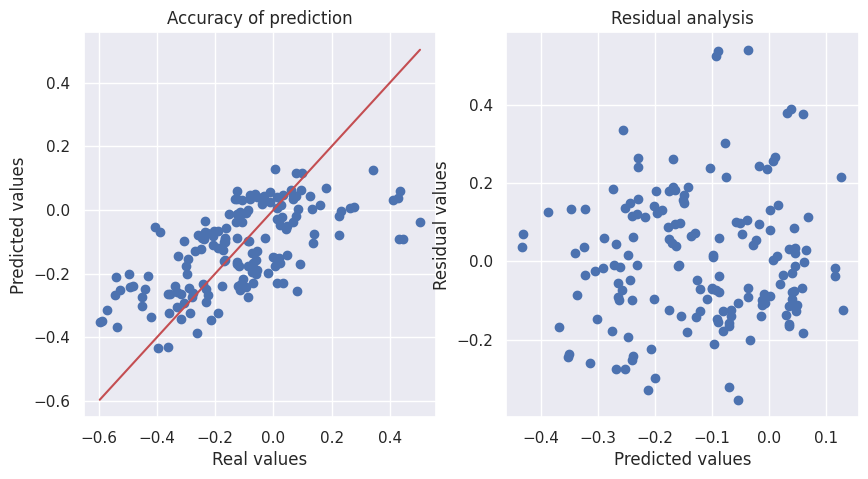

180d_return
------------------------------------------------------------
R²:  0.7050670066434803
Mean absolute error :  0.10887149861305069
% of missclassified sign :  9
% of missclassified profit :  5
% of missclassified loss :  4


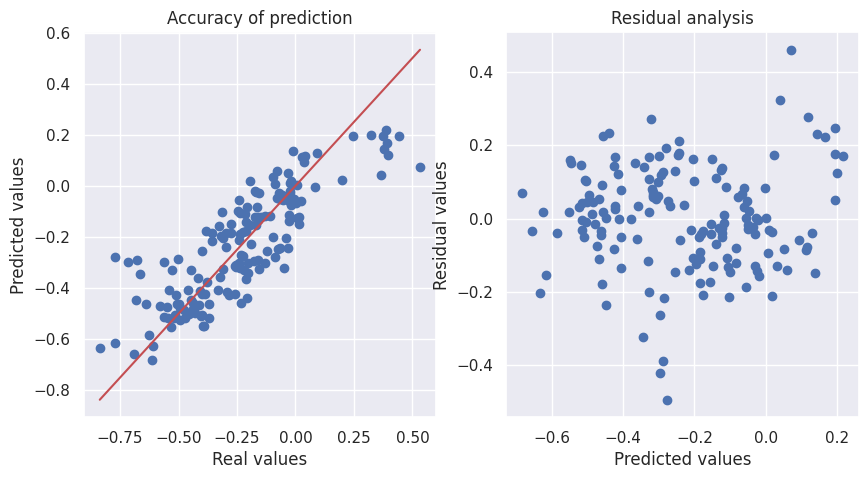

In [ ]:
from sklearn.linear_model import Ridge

for i in range(len(target_return_names)):

  ridge_regressor = Ridge()
  ridge_regressor.fit(X_train, Y_train.loc[:,target_return_names[i]])

  # Make predictions on the testing set
  Y_pred = ridge_regressor.predict(X_test)

  # Print regression report
  regression_report(Y_test.loc[:,target_return_names[i]], Y_pred,target_return_names[i])
  

### Lasso 
not working put all coef to 0

30d_return
------------------------------------------------------------
R²:  -0.0032594775618415284
Mean absolute error :  0.10124726886131101
% of missclassified sign :  31
% of missclassified profit :  0
% of missclassified loss :  31


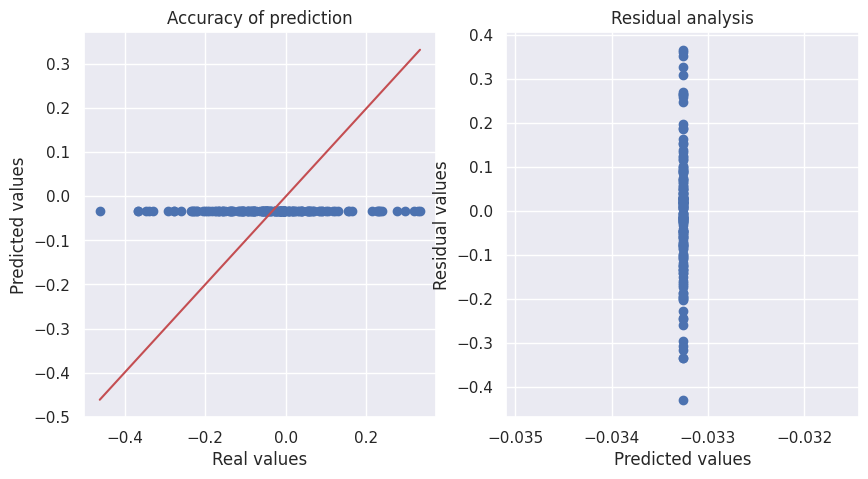

90d_return
------------------------------------------------------------
R²:  -2.649180406422147e-05
Mean absolute error :  0.1695063026280392
% of missclassified sign :  30
% of missclassified profit :  0
% of missclassified loss :  30


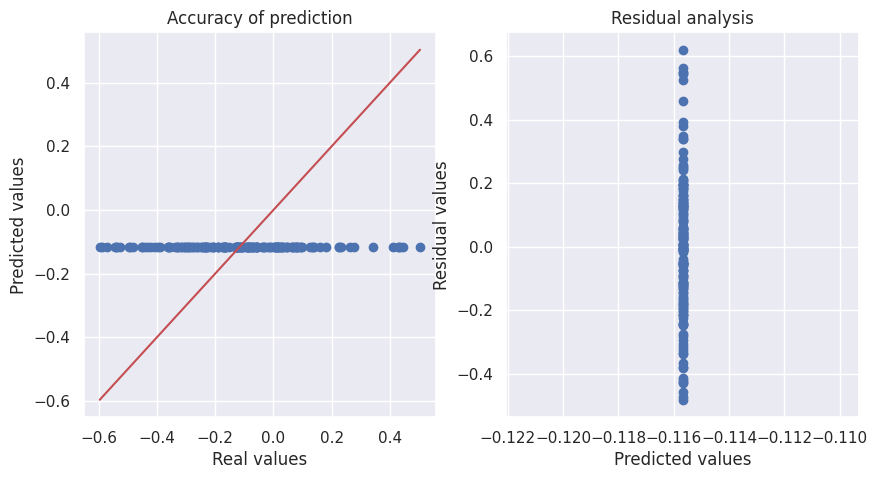

180d_return
------------------------------------------------------------
R²:  0.09023916031833878
Mean absolute error :  0.19503935806772754
% of missclassified sign :  14
% of missclassified profit :  0
% of missclassified loss :  14


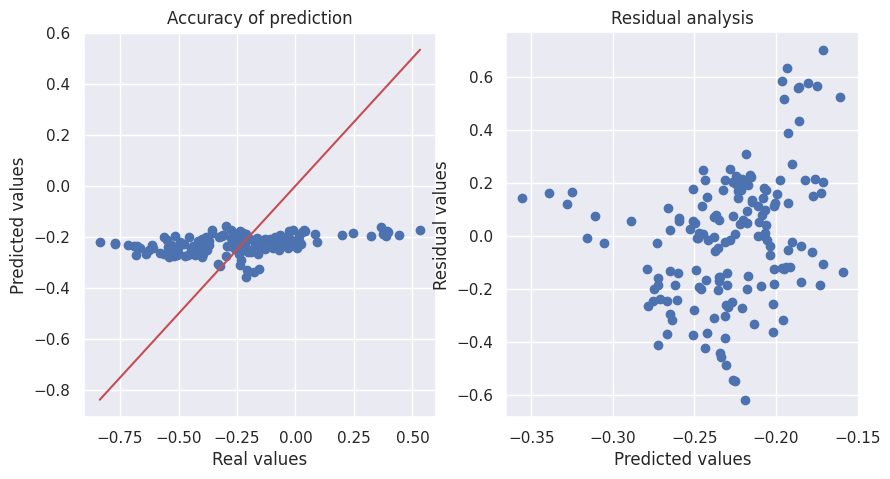

In [ ]:
from sklearn.linear_model import LassoLars

for i in range(len(target_return_names)):

  lasso_regressor = LassoLars(alpha=0.1)
  lasso_regressor.fit(X_train.to_numpy(), Y_train.loc[:,target_return_names[i]])

  # Make predictions on the testing set
  Y_pred = lasso_regressor.predict(X_test)

  # Print regression report
  regression_report(Y_test.loc[:,target_return_names[i]], Y_pred,target_return_names[i])

###SVM regression

30d_return
------------------------------------------------------------
R²:  0.7457827322146466
Mean absolute error :  0.056780369895624655
% of missclassified sign :  16
% of missclassified profit :  13
% of missclassified loss :  3


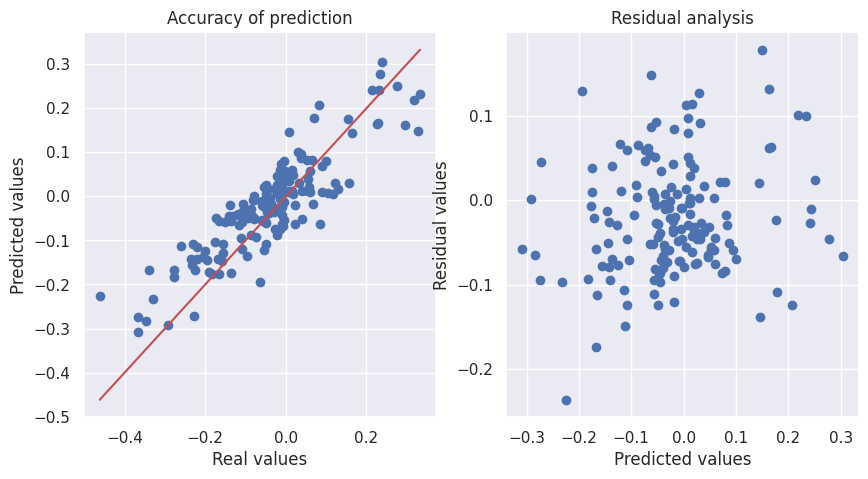

90d_return
------------------------------------------------------------
R²:  0.8729522538169846
Mean absolute error :  0.06532685583620032
% of missclassified sign :  14
% of missclassified profit :  0
% of missclassified loss :  14


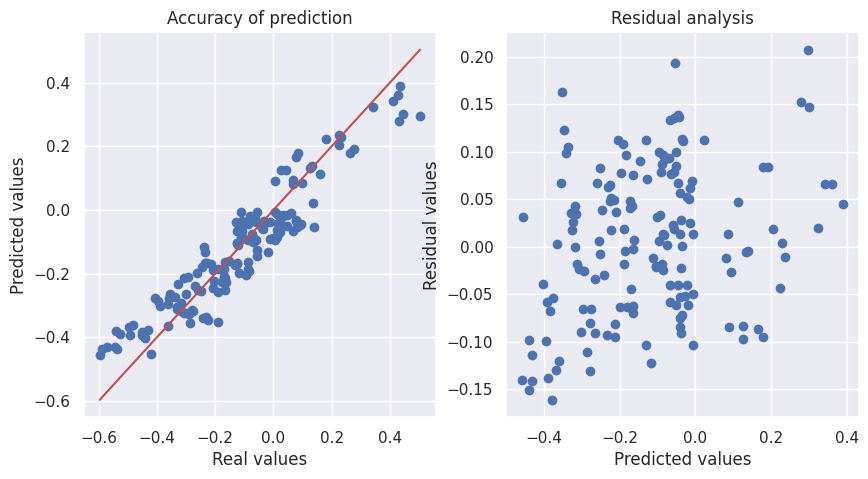

180d_return
------------------------------------------------------------
R²:  0.9208397507590879
Mean absolute error :  0.06098914465992087
% of missclassified sign :  6
% of missclassified profit :  2
% of missclassified loss :  4


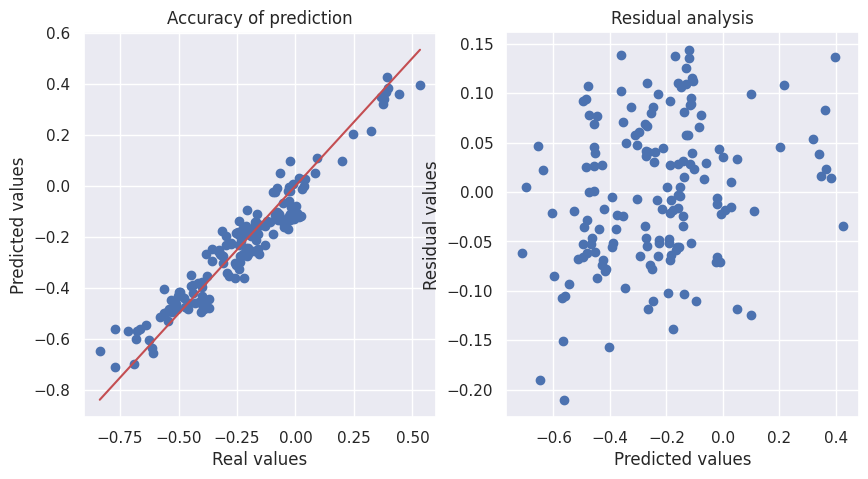

In [ ]:
from sklearn.svm import SVR

for i in range(len(target_return_names)):

  # Train a Naive Bayes classifier on the training set
  SVM_regressor = SVR()
  SVM_regressor.fit(X_train, Y_train.loc[:,target_return_names[i]])

  # Make predictions on the testing set
  Y_pred = SVM_regressor.predict(X_test)


  # Print regression report
  regression_report(Y_test.loc[:,target_return_names[i]], Y_pred,target_return_names[i])

### Gradiant Boosting

30d_return
------------------------------------------------------------
R²:  0.7527036376334094
Mean absolute error :  0.052572487820500224
% of missclassified sign :  17
% of missclassified profit :  8
% of missclassified loss :  9


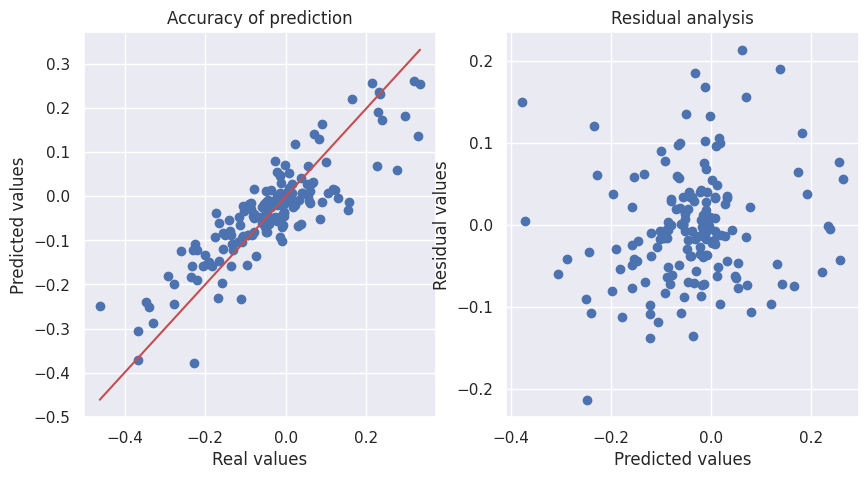

90d_return
------------------------------------------------------------
R²:  0.7955075250763127
Mean absolute error :  0.07337170895189739
% of missclassified sign :  11
% of missclassified profit :  3
% of missclassified loss :  9


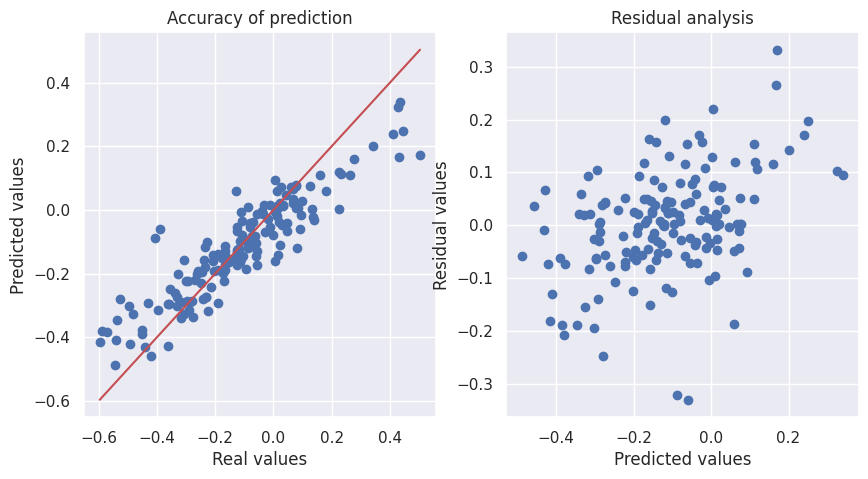

180d_return
------------------------------------------------------------
R²:  0.8820268077534102
Mean absolute error :  0.06627337611618771
% of missclassified sign :  6
% of missclassified profit :  2
% of missclassified loss :  4


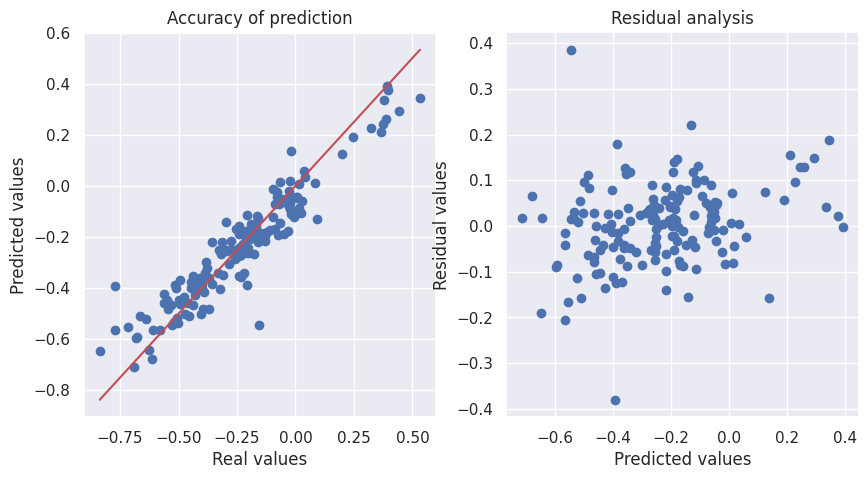

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

for i in range(len(target_return_names)):

  # Train a Naive Bayes classifier on the training set
  GBoost_regressor = GradientBoostingRegressor()
  GBoost_regressor.fit(X_train, Y_train.loc[:,target_return_names[i]])

  # Make predictions on the testing set
  Y_pred = GBoost_regressor.predict(X_test)


  # Print regression report
  regression_report(Y_test.loc[:,target_return_names[i]], Y_pred,target_return_names[i])

### (ML)

30d_return
------------------------------------------------------------
R²:  0.38119251441050794
Mean absolute error :  0.07807128660066963
% of missclassified sign :  19
% of missclassified profit :  10
% of missclassified loss :  9


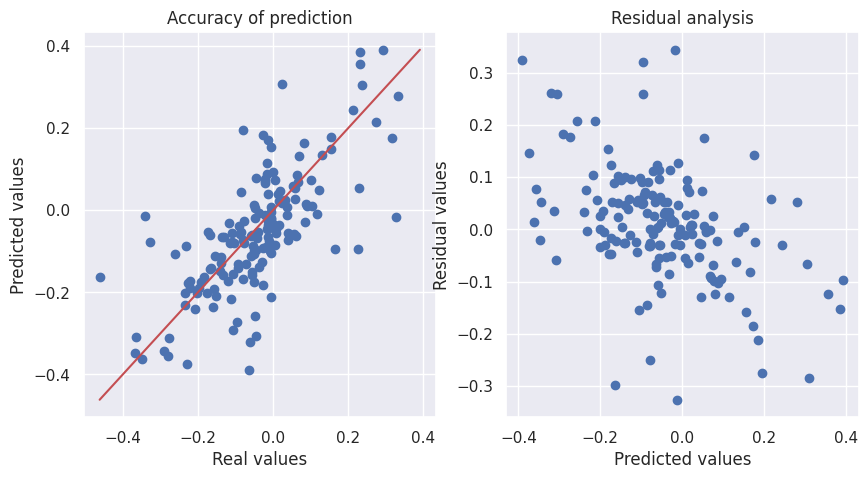

90d_return
------------------------------------------------------------
R²:  0.7104238831602865
Mean absolute error :  0.09108038087018987
% of missclassified sign :  11
% of missclassified profit :  4
% of missclassified loss :  7


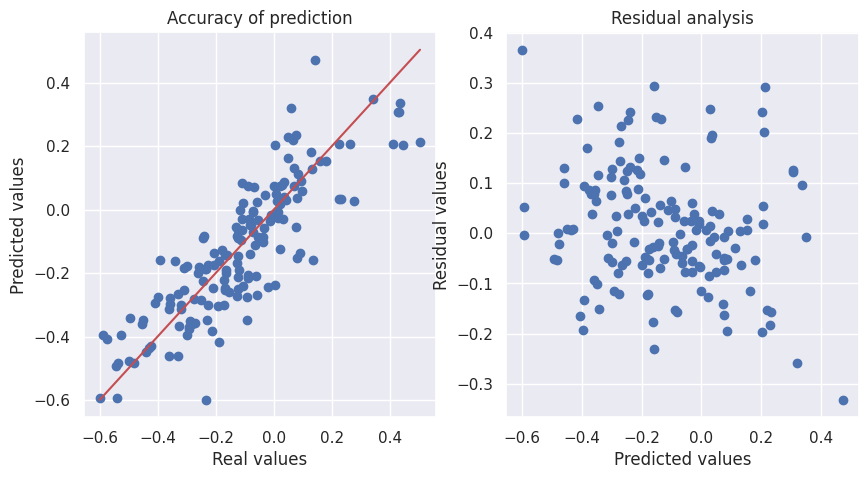

180d_return
------------------------------------------------------------
R²:  0.7546444421506919
Mean absolute error :  0.1005807924706587
% of missclassified sign :  10
% of missclassified profit :  8
% of missclassified loss :  3


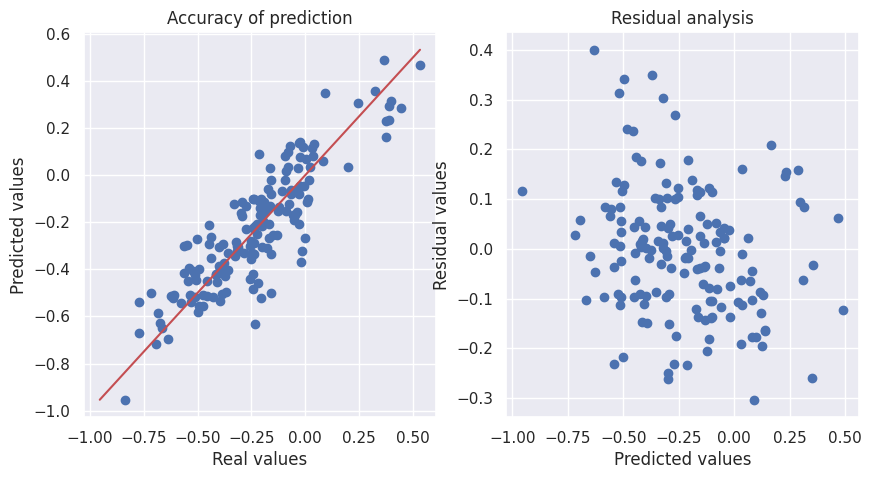

In [ ]:
from sklearn.neural_network import MLPRegressor

for i in range(len(target_return_names)):

  # Train a Naive Bayes classifier on the training set
  ML_regressor = MLPRegressor()
  ML_regressor.fit(X_train, Y_train.loc[:,target_return_names[i]])

  # Make predictions on the testing set
  Y_pred = ML_regressor.predict(X_test)

  # Print regression report
  regression_report(Y_test.loc[:,target_return_names[i]], Y_pred,target_return_names[i])